In [ ]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile
import cv2
import tensorflow as tf


### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/"

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
!dir
base_path = 'BTPS^3/Signboard Annotation/BSVSO Datasets/'
images_boxable_fname = 'train-images-boxable.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

ayat_hadis_songkolon_ics.pdf  CROPPER	   Model\ Files.zip  Signboard_Detector
BTPS^3			      kaggle	   OCR		     Study
Classroom		      kaggle.json  OS
Colab\ Notebooks	      ML	   SAINT


In [ ]:
images_boxable = pd.read_csv(os.path.join(base_path, images_boxable_fname))
images_boxable.head()

,filename,image_url
0,1.png,BTPS^3/Signboard Annotation/BSVSO Datasets/Tes...
1,2.png,BTPS^3/Signboard Annotation/BSVSO Datasets/Tes...
2,3.png,BTPS^3/Signboard Annotation/BSVSO Datasets/Tes...
3,4.png,BTPS^3/Signboard Annotation/BSVSO Datasets/Tes...
4,5.png,BTPS^3/Signboard Annotation/BSVSO Datasets/Tes...


In [ ]:
annotations_bbox = pd.read_csv(os.path.join(base_path, annotations_bbox_fname))
annotations_bbox.head()

,filename,class_name,xmin,ymin,xmax,ymax
0,1.png,signboard,192,174,743,340
1,2.png,signboard,416,217,687,367
2,3.png,signboard,467,161,796,296
3,4.png,signboard,388,287,592,404
4,5.png,signboard,273,238,606,342


In [ ]:
class_descriptions = pd.read_csv(os.path.join(base_path, class_descriptions_fname))
class_descriptions.head()

,name,class
0,signboard,signboard
1,signboard,signboard
2,signboard,signboard
3,signboard,signboard
4,signboard,signboard


### Show one image by using these three tables

In [ ]:
print('length of the images_boxable: %d' %(len(images_boxable)) )
print('First image in images_boxable👇')
img_name = images_boxable['filename'][0]
img_url =  images_boxable['image_url'][0]
print('\t image_name: %s' % (img_name))
print('\t img_url: %s' % (img_url))
print('')
print('length of the annotations_bbox: %d' %(len(annotations_bbox)))
print('The number of bounding boxes are larger than number of images.')
print('')
print('length of the class_descriptions: %d' % (len(class_descriptions)))
img = io.imread(img_url)

length of the images_boxable: 329
First image in images_boxable👇
	 image_name: 1.png
	 img_url: BTPS^3/Signboard Annotation/BSVSO Datasets/Test Data/1.png

length of the annotations_bbox: 329
The number of bounding boxes are larger than number of images.

length of the class_descriptions: 12632


(600, 1000, 4)


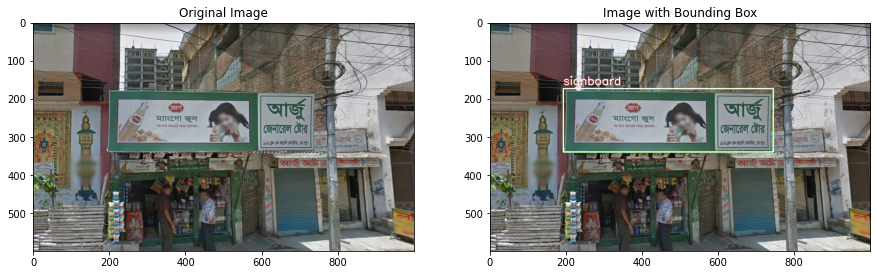

In [ ]:
#height, width = img.shape # 2d image
height, width,_ = img.shape # 2d image # 3d image
print(img.shape)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
img_id = img_name
bboxs = annotations_bbox[annotations_bbox['filename']==img_id]
#print(bboxs,img_id)
img_bbox = img.copy()
for index, row in bboxs.iterrows():
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']

    label_name = row['class_name']
    #print(xmin,ymin,xmax,ymax,label_name)
    class_series = class_descriptions[class_descriptions['name']==label_name]
    class_name = class_series['class'].values[0]
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,class_name,(xmin,ymin-10), font, 1,(255,0,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

In [ ]:
# Find the label_name for 'signboard' class
person_pd = class_descriptions[class_descriptions['class']=='signboard']
label_name_person = person_pd['name'].values[0]
print(person_pd)

            name      class
0      signboard  signboard
1      signboard  signboard
2      signboard  signboard
3      signboard  signboard
4      signboard  signboard
...          ...        ...
12627  signboard  signboard
12628  signboard  signboard
12629  signboard  signboard
12630  signboard  signboard
12631  signboard  signboard

[12632 rows x 2 columns]


**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [ ]:
person_bbox = annotations_bbox[annotations_bbox['class_name']==label_name_person]

In [ ]:
print('There are %d signboards in the dataset' %(len(person_bbox)))
person_img_id = person_bbox['filename']

There are 329 signboards in the dataset


In [ ]:
person_img_id = np.unique(person_img_id)
print('There are %d images which contain signboards' % (len(person_img_id)))

There are 200 images which contain signboards


In [ ]:
classes = ['signboard']

In [ ]:
train_imgs = os.listdir(os.path.join('BTPS^3/Signboard Annotation/BSVSO Datasets/Test Data/'))
print('number of training images: ',len(train_imgs) ) # subtract one because there is one hidden file named '.DS_Store'

label_names = [label_name_person]
print(label_names)

number of training images:  200
['signboard']


In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])
# Find boxes in each image and put them in a dataframe
cnt = 1
cnt2= 0
for i in sorted(os.listdir(os.path.join('BTPS^3/Signboard Annotation/BSVSO Datasets/Test Data/')),key=numericalSort):
    sys.stdout.write('Parse train_imgs ' + str(cnt2) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = i
    img_id = img_name
    tmp_df = annotations_bbox[annotations_bbox['filename']==img_id]
    cnt2+=1
    for index, row in tmp_df.iterrows():
        cnt+=1
        labelName = row['class_name']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['xmin'], 
                                            'XMax': row['xmax'], 
                                            'YMin': row['ymin'], 
                                            'YMax': row['ymax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)
            else: print(labelName,label_names[i])
print('cnt: ',cnt)
print('cnt2: ',cnt2)

cnt:  330
cnt2:  200


In [ ]:
train_df.to_csv(os.path.join(base_path, 'test.csv'))

### Write train.csv to annotation.txt

In [ ]:
# print(train_df.head())
train_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# For training
f= open(base_path + "test_annotation.txt","w+")
for idx, row in train_df.iterrows():
    sys.stdout.write(str(idx) + '\r')
    sys.stdout.flush()
    #img = cv2.imread(("BTPS^3/Signboard Annotation/BSVSO Datasets/PIL_RGB/" + row['FileName']))
    #height, width = img.shape[:2]
    x1 = int(row['XMin'])# * width)
    x2 = int(row['XMax'])# * width)
    y1 = int(row['YMin'])# * height)
    y2 = int(row['YMax'])# * height)
    
    google_colab_file_path = "BTPS^3/Signboard Annotation/BSVSO Datasets/Test Data/"  #base_path +'train'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['ClassName']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')
f.close()